In [1]:
import numpy as np
import pandas as pd
import pomegranate as pg

## Problem 1

In [2]:
A = pg.DiscreteDistribution({"T": 0.3, "F":0.7})
B = pg.ConditionalProbabilityTable([
    ["T", "T", 0.8],
    ["F", "T", 0.4],
    ["T", "F", 0.2],
    ["F", "F", 0.6]
], [A])
C = pg.ConditionalProbabilityTable([
    ["T","T","T",0.99],
    ["F","T","T",0.7],
    ["T","F","T",0.5],
    ["F","F","T",0.1],
    ["T","T","F",0.01],
    ["F","T","F",0.3],
    ["T","F","F",0.5],
    ["F","F","F",0.9]
], [A,B])
D = pg.ConditionalProbabilityTable([
    ["T","T", 0.2],
    ["T","F",0.8],
    ["F","T",0.55],
    ["F","F",0.45]
], [B])

In [3]:
nodeA = pg.Node(A, name="A")
nodeB = pg.Node(B, name="B")
nodeC = pg.Node(C, name="C")
nodeD = pg.Node(D, name="D")

In [4]:
model = pg.BayesianNetwork("Problem1")
model.add_states(nodeA, nodeB, nodeC, nodeD)

model.add_edge(nodeA, nodeB)
model.add_edge(nodeA, nodeC)
model.add_edge(nodeB, nodeC)
model.add_edge(nodeB, nodeD)

In [5]:
model.bake()

### a) $P( A=T | C = T, D = T)$

In [8]:
np.prod(
    model.probability([
        ["T", "F", "T", "T"],
        ["T", "T", "T", "T"]
    ])
)

0.0007840799999999999

### b) $P(A=T | D=F)$

In [9]:
np.prod(
    model.probability([
        ["T", "T", "T", "F"],
        ["T", "F", "T", "F"],
        ["T", "T", "F", "F"],
        ["T", "F", "F", "F"]
    ])
)

6.651279360000006e-08

### c) $P(B=T|C=T)$

In [10]:
np.prod(
    model.probability([
        ["T", "T", "T", "T"],
        ["T", "T", "T", "F"],
        ["F", "T", "T", "T"],
        ["F", "T", "T", "F"]
    ])
)

5.551942769049598e-05

### d) $P(B=T |A=T, C=T)$

In [11]:
np.prod(
    model.probability([
        ["T", "T", "T", "T"],
        ["T", "T", "T", "F"],
    ])
)

0.009032601600000002

### e) $P(C=T|A=F,B=F,D=F)$

In [12]:
model.probability([
    ["F", "F", "T", "F"]
])

0.018899999999999997

## Problem 2

In [13]:
from sklearn.datasets import load_boston, load_iris
from sklearn.naive_bayes import CategoricalNB, GaussianNB
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import numpy as np
import pandas as pd

In [14]:
X = load_iris().data
y = load_iris().target

In [15]:
X_train, X_unseen, y_train, y_unseen = train_test_split(X, y, test_size=0.3, random_state=220)

In [16]:
def get_quartiles(X, k=4):
    qs = [[] for i in range(k)]
    
    for c in range(X.shape[1]):
        for i in range(1, k+1):
            qs[i-1].append( 
                np.quantile(X[:, c], 1/i) 
            )
    
    return np.array(qs)

In [17]:
def to_class(V, q):
    idxs= []
    for interval in zip(q[:-1], q[1:]):
        max_, min_ = interval
        idxs.append( 
            np.where( (V>min_) & (V<=max_) )[0]
        )
    idxs.append( np.where(V<=q[-1]) )
    idxs.append( np.where(V>q[0]) )
    
    for i, idx in enumerate(idxs[::-1]):
        V[idx] = i
    return V

In [18]:
quartiles = get_quartiles(X_train)

In [19]:
for i in range(X.shape[1]):
    X_train[:, i] = to_class(X_train[:, i], quartiles[:, i])
    X_unseen[:, i] = to_class(X_unseen[:, i], quartiles[:, i])

### Naive Bayes

In [20]:
grid = {
    "alpha": [0.1, 1, 10, 25, 75],
    "fit_prior": [True, False],
    "min_categories": [None, 4]
}

nb = GridSearchCV(
        CategoricalNB(),
        param_grid=grid,
        cv=5,
        scoring="accuracy"
).fit(X_train, y_train)

In [21]:
nb.best_params_

{'alpha': 1, 'fit_prior': True, 'min_categories': None}

In [22]:
nb.best_score_

0.9238095238095239

In [23]:
%timeit nb = CategoricalNB().fit(X_train, y_train)

1.11 ms ± 60.1 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [24]:
%timeit preds = nb.predict(X_unseen)

105 µs ± 3.52 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [26]:
preds = nb.predict(X_unseen)

In [27]:
print(classification_report(y_unseen, preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.94      0.88      0.91        17
           2       0.86      0.92      0.89        13

    accuracy                           0.93        45
   macro avg       0.93      0.94      0.93        45
weighted avg       0.94      0.93      0.93        45



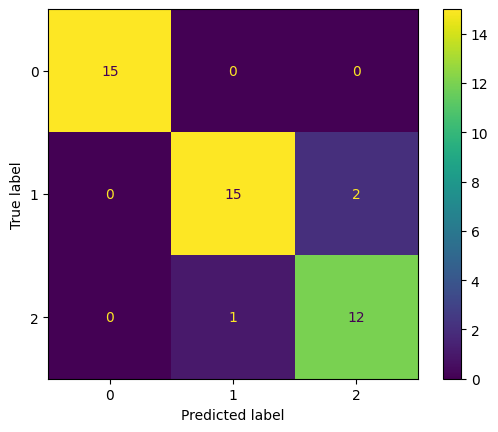

In [28]:
ConfusionMatrixDisplay(
    confusion_matrix(y_unseen, preds)
).plot()

### Random Forest

In [29]:
grid={
    "criterion": ["entropy", "gini"],
    "max_depth": [None] + list(range(2, 20, 5)),
    "min_samples_leaf": range(1, 10+1, 3)
}

rf = GridSearchCV(
    RandomForestClassifier(),
    param_grid=grid,
    cv=5,
    scoring="accuracy"
).fit(X_train, y_train)

In [30]:
rf.best_params_

{'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1}

In [31]:
rf.best_score_

0.9333333333333333

In [32]:
%timeit rf = RandomForestClassifier(criterion="entropy", max_depth=None, min_samples_leaf=1).fit(X_train, y_train)

105 ms ± 1.19 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [34]:
%timeit preds = rf.predict(X_unseen)

9.04 ms ± 192 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [35]:
preds = rf.predict(X_unseen)

In [36]:
print(classification_report(y_unseen, preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.94      0.88      0.91        17
           2       0.86      0.92      0.89        13

    accuracy                           0.93        45
   macro avg       0.93      0.94      0.93        45
weighted avg       0.94      0.93      0.93        45



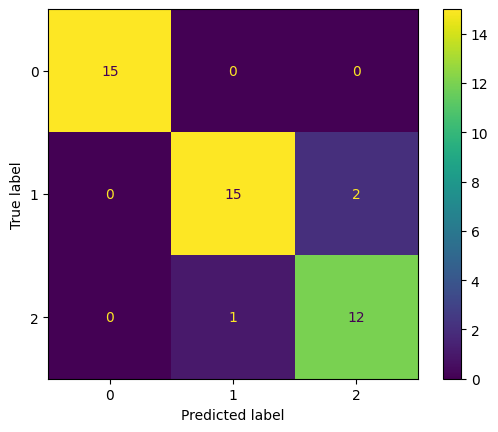

In [37]:
ConfusionMatrixDisplay(
    confusion_matrix(y_unseen, preds)
).plot()